In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple

### Input

In [2]:
# read results into dataframe
flow_path= '../opt_hype/0058308.txt'

### Process Data

In [3]:
# read HYPE output into dataframe
flow = pd.read_csv(flow_path, index_col=0, sep='\t')

# Drop the first row if it's unnecessary (e.g., metadata or headers)
flow = flow.drop(flow.index[0])

# Ensure the index is datetime
flow.index = pd.to_datetime(flow.index)

# Ensure the 'cout' and 'rout' columns are of float type
flow['cout'] = flow['cout'].astype(float)
flow['rout'] = flow['rout'].astype(float)

    
# Replace -9999 with NaN
flow.replace(-9999, np.nan, inplace=True)

In [4]:
# find average annual obs
average_annual_obs = flow['rout'].groupby(flow.index.dayofyear).mean()

# Create a DataFrame to store the averages
average_annual = pd.DataFrame({
    'obs': average_annual_obs
})


In [5]:
# Convert the day-of-year index to datetime format
average_annual.index = pd.to_datetime(average_annual.index, format='%j').strftime('%m-%d')

In [6]:
# Drop the last row
average_annual = average_annual.iloc[:-1]

In [7]:
# Extract unique years from benchmark DataFrame
years = flow.index.year.unique()

In [8]:
# Prepare a list to hold DataFrames for each year
merged_dfs = []

for year in years:
    # Create a DataFrame with the year added to the month-day index
    annual_average_year = average_annual.copy()
    annual_average_year.index = pd.to_datetime(annual_average_year.index + f"-{year}", format='%m-%d-%Y')
    
    # Filter benchmark data for the current year
    benchmark_year = flow[flow.index.year == year]
    
    # Merge the benchmark data with annual_average data for the current year
    merged_year = pd.merge(benchmark_year, annual_average_year, left_index=True, right_index=True, how='left')
    
    # Append to the list of DataFrames
    merged_dfs.append(merged_year)

In [9]:
# Concatenate all DataFrames
result_df = pd.concat(merged_dfs)

# Rename the column for clarity
result_df.rename(columns={'obs': 'obs_model'}, inplace=True)

In [10]:
result_df

,cout,rout,obs_model
DATE,,,
1980-01-01,0.000,NaN,NaN
1980-01-02,0.008,NaN,NaN
1980-01-03,0.045,NaN,NaN
1980-01-04,0.097,NaN,NaN
1980-01-05,0.740,NaN,NaN
...,...,...,...
2015-12-27,0.003,NaN,NaN
2015-12-28,0.003,NaN,NaN
2015-12-29,0.003,NaN,NaN


### Plot

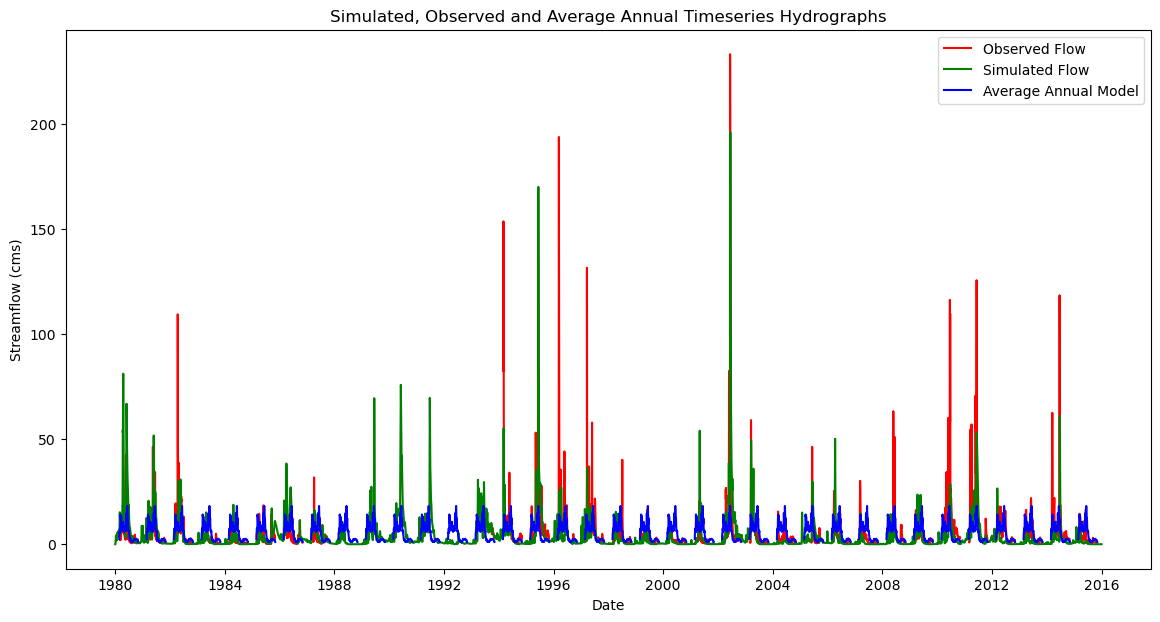

In [19]:
# Plotting the obs_model column against the index
plt.figure(figsize=(14, 7))
plt.plot(result_df.index, result_df['rout'], label='Observed Flow', color='red', linestyle='-')
plt.plot(result_df.index, result_df['cout'], label='Simulated Flow', color='green', linestyle='-')
plt.plot(result_df.index, result_df['obs_model'], label='Average Annual Model', color='blue', linestyle='-')

# Adding titles and labels
plt.title('Simulated, Observed and Average Annual Timeseries Hydrographs')
plt.xlabel('Date')
plt.ylabel('Streamflow (cms)')
plt.legend()

# Display the plot
plt.show()

### KGE Calculations

In [12]:
def remove_invalid_values(simulated, observed):
    valid_indices = np.where((observed != -9999) & (simulated != -9999))
    return simulated[valid_indices], observed[valid_indices]


In [13]:
def remove_nan_rows(
    array1: np.ndarray, 
    array2: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Removes rows from two arrays where either array has NaN values.
    Retains the first row if it doesn't have any NaN values.
    
    Arguments:
    array1: np.ndarray:
        First input array
    array2: np.ndarray
        Second input array
    
    Returns:
    cleaned_array1: : np.ndarray
        Cleaned array1 without NaN rows
    cleaned_array2: np.ndarray
        Cleaned array2 without NaN rows
    """
    # checks for and removes any rows where either array has a value of NaN at a corresponding row 
    # including the first one
    
    mask = np.logical_and(~np.isnan(array1), ~np.isnan(array2))
    if not np.isnan(array1[0]) and not np.isnan(array2[0]):
        mask[0] = True
    cleaned_array1 = array1[mask]
    cleaned_array2 = array2[mask]
    return cleaned_array1, cleaned_array2

In [14]:
def compute_kge(simulated_array, observed_array):
    """
    Computes KGE (Kling-Gupta Efficiency) between observed and simulated values.

    Parameters:
        observed_array (numpy.ndarray): Array of observed values.
        simulated_array (numpy.ndarray): Array of simulated values.

    Returns:
        float: KGE value.
    """
    
    # Calculate Pearson correlation coefficient
    correlation_coefficient = np.corrcoef(observed_array, simulated_array)[0, 1]
    
    # Calculate standard deviation ratio
    std_observed = np.std(observed_array)
    std_simulated = np.std(simulated_array)
    std_ratio = std_simulated / std_observed
    
    # Calculate bias ratio
    mean_observed = np.mean(observed_array)
    mean_simulated = np.mean(simulated_array)
    bias_ratio = mean_simulated / mean_observed
    
    # Calculate KGE
    kge = 1 - np.sqrt((correlation_coefficient - 1)**2 + (std_ratio - 1)**2 + (bias_ratio - 1)**2)
    
    return kge

#### Inputs

In [17]:
sim_column= 'obs_model'

obs_column= 'rout'

calibration_ranges = [('1981-01-01', '1984-12-31'),
               ('1990-01-01', '1998-12-31'),
               ('2004-01-01', '2007-12-31'),
               ('2013-01-01', '2015-12-31')]

validation_ranges = [('1985-01-01', '1989-12-31'),
               ('1999-01-01', '2003-12-31'),
               ('2008-01-01', '2012-12-31')]


##### Calculate KGE

In [18]:
# Create empty lists to store observed and simulated data for each year range
simulated_data_cal = []
observed_data_cal = []
simulated_data_val = []
observed_data_val = []

# Convert the index to datetime if it's not already in datetime format
if not isinstance(result_df.index, pd.DatetimeIndex):
    result_df.index = pd.to_datetime(result_df.index)

# Process and filter DataFrame based on calibration period
for start_date, end_date in calibration_ranges:
    trimmed_df1 = result_df.loc[start_date:end_date]
    simulated_data_cal.append(trimmed_df1[sim_column].values.astype(float))  # Convert to float array
    observed_data_cal.append(trimmed_df1[obs_column].values.astype(float))  # Convert to float array

# Process and filter DataFrame based on validation period
for start_date, end_date in validation_ranges:
    trimmed_df2 = result_df.loc[start_date:end_date]
    simulated_data_val.append(trimmed_df2[sim_column].values.astype(float))  # Convert to float array
    observed_data_val.append(trimmed_df2[obs_column].values.astype(float))  # Convert to float array

# Concatenate the lists of arrays into NumPy arrays
simulated_array_cal = np.concatenate(simulated_data_cal)
observed_array_cal = np.concatenate(observed_data_cal)
simulated_array_val = np.concatenate(simulated_data_val)
observed_array_val = np.concatenate(observed_data_val)

# Remove invalid values (-9999) after concatenating arrays
simulated_array_cal, observed_array_cal = remove_invalid_values(simulated_array_cal, observed_array_cal)
simulated_array_val, observed_array_val = remove_invalid_values(simulated_array_val, observed_array_val)

# check for and remove rows with nan
simulated_array_cal, observed_array_cal= remove_nan_rows(simulated_array_cal, observed_array_cal)
simulated_array_val, observed_array_val= remove_nan_rows(simulated_array_val, observed_array_val)

# Check if both arrays have the same length
if len(simulated_array_cal) != len(observed_array_cal):
    raise ValueError(f"Observed and simulated data arrays for file {filename} have different lengths!")

# Check if both arrays have the same length
if len(simulated_array_val) != len(observed_array_val):
    raise ValueError(f"Observed and simulated data arrays for file {filename} have different lengths!")

# Calculate KGE and bias for the current file
cal_kge = compute_kge(simulated_array_cal, observed_array_cal)

val_kge = compute_kge(simulated_array_val, observed_array_val)

print(f'KGE for the calibration period = {cal_kge}')
print(f'KGE for the validation period = {val_kge}')

KGE for the calibration period = 0.07964178185399451
KGE for the validation period = 0.04634304513480958
